In [ ]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt

In [ ]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [ ]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['ADBE','MSFT']

df = yf.download(tickers, start, end)['Close']
df

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2013-01-02,38.340000,27.620001
2013-01-03,37.750000,27.250000
2013-01-04,38.130001,26.740000
2013-01-07,37.939999,26.690001
2013-01-08,38.139999,26.549999
...,...,...
2018-12-24,205.160004,94.129997
2018-12-26,222.949997,100.559998
2018-12-27,225.139999,101.180000


In [ ]:
S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, _ = coint(S1, S2)
pvalue

0.04452696271616674

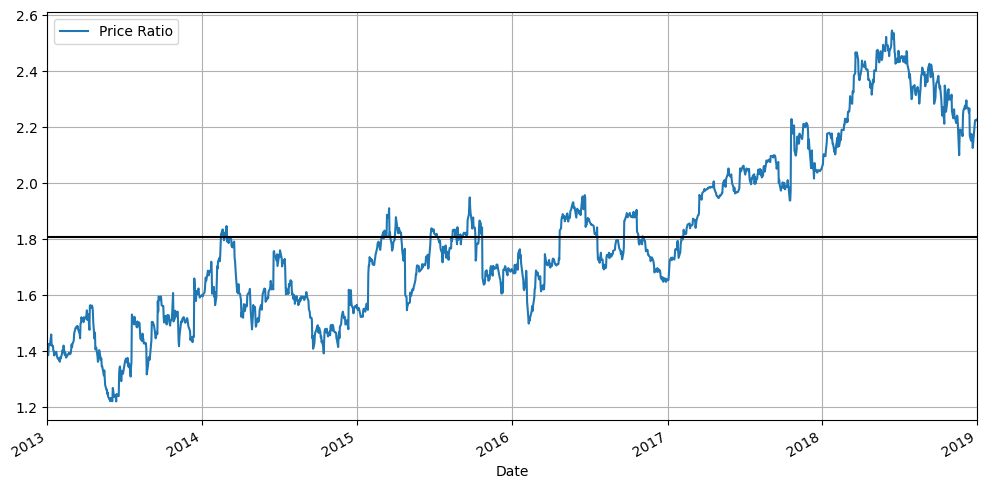

In [ ]:
df['ratio'] = df['ADBE']/df['MSFT']
df['ratio'].plot(figsize=(12,6))
plt.axhline(df['ratio'].mean(), color='black')
plt.xlim('2013-01-01', '2019-01-01')
plt.legend(['Price Ratio'])
plt.grid()

In [ ]:
df['mavg5'] = df['ratio'].rolling(window=5, center=False).mean()
df['mavg20'] = df['ratio'].rolling(window=20, center=False).mean()
df['mavg60'] = df['ratio'].rolling(window=60, center=False).mean()
df['roc'] = df['ratio'].pct_change(periods=5)
df['std_20'] = df['ratio'].rolling(window=20, center=False).std()
df['lag'] = df['ratio'].shift(1)


In [ ]:
X = df[['mavg5', 'mavg20', 'mavg60', 'roc', 'std_20', 'lag']]
y = df['ratio']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

Mean Squared Error: 0.0020558415870679868
Mean Absolute Error: 0.03530566152497207


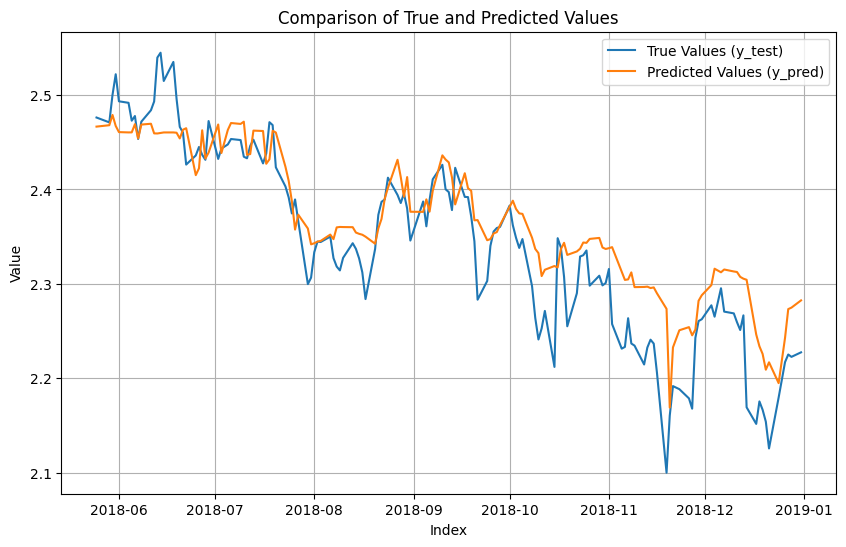

In [ ]:
y_pred=model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="True Values (y_test)")
plt.plot(y_test.index, y_pred, label="Predicted Values (y_pred)")

# Add labels, title, and legend
plt.title("Comparison of True and Predicted Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df['Predicted_Ratio'] = np.nan
df.iloc[-len(y_test):, df.columns.get_loc('Predicted_Ratio')] = y_pred

In [ ]:
df['Buy_Signal'] = (df['Predicted_Ratio'] > df['ratio'] + mae / 5)
df['Sell_Signal'] = (df['Predicted_Ratio'] + mae / 5 < df['ratio'])

df['PnL'] = 0
positions = {'ADBE': 0, 'MSFT': 0}

# Iterate over positional indices and access the actual index via df.index
for i in range(len(df)):
    idx = df.index[i]  # Get the actual index value

    if df.loc[idx, 'Buy_Signal']:  # Use loc with the index value
        positions['ADBE'] += 10
        positions['MSFT'] -= 10
    elif df.loc[idx, 'Sell_Signal']:
        positions['ADBE'] -= 10
        positions['MSFT'] += 10

    # Update PnL
    df.loc[idx, 'PnL'] = positions['ADBE'] * df.loc[idx, 'ADBE'] + positions['MSFT'] * df.loc[idx, 'MSFT']

# Filter rows where 'Predicted_Ratio' is not NaN
filtered_df = df[df['Predicted_Ratio'].notna()]

# Calculate PnL change
filtered_df['PnL_Change'] = filtered_df['PnL'].diff()

print(filtered_df[['PnL']])


Ticker               PnL
Date                    
2018-05-25  -1451.999969
2018-05-29  -1441.800003
2018-05-30  -2968.999939
2018-05-31  -4513.200073
2018-06-01  -6020.799866
...                  ...
2018-12-24  68838.603973
2018-12-26  77105.699615
2018-12-27  79334.399414
2018-12-28  79781.003571
2018-12-31  82282.203827

[151 rows x 1 columns]


<ipython-input-22-7c44f402996b>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1451.9999694824219' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[idx, 'PnL'] = positions['ADBE'] * df.loc[idx, 'ADBE'] + positions['MSFT'] * df.loc[idx, 'MSFT']
<ipython-input-22-7c44f402996b>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['PnL_Change'] = filtered_df['PnL'].diff()


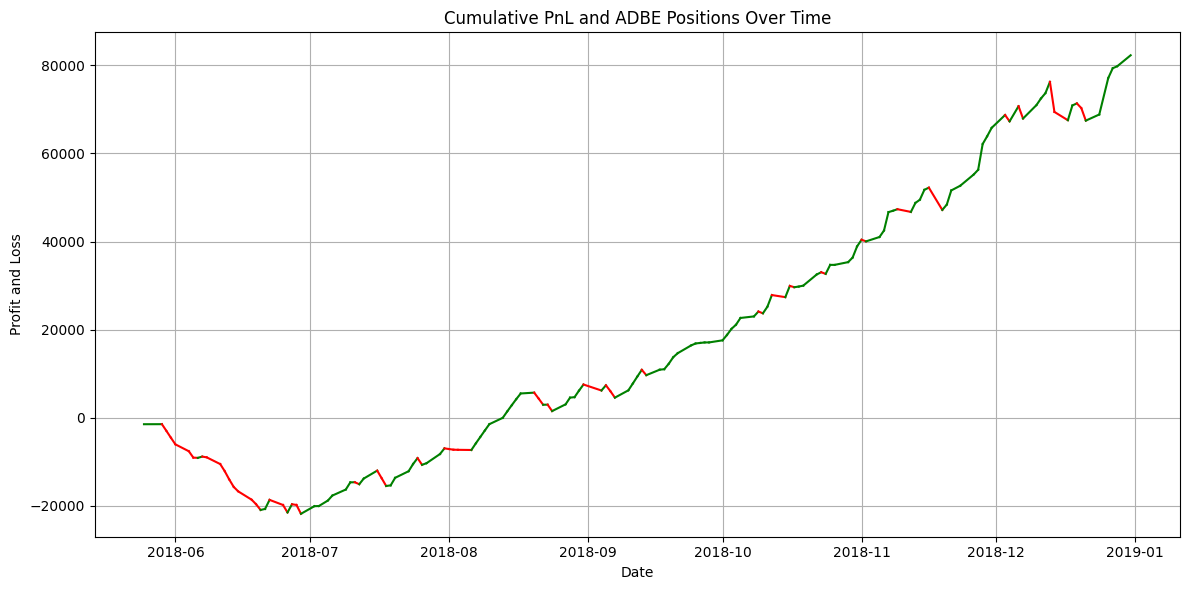

In [ ]:
# Plot the PnL with color-coded segments
fig, ax1 = plt.subplots(figsize=(12, 6))

for i in range(1, len(filtered_df)):
    if filtered_df['PnL_Change'].iloc[i] > 0:  # PnL is increasing
        ax1.plot(filtered_df.index[i-1:i+1],
                 filtered_df['PnL'].iloc[i-1:i+1],
                 color='green')
    else:  # PnL is decreasing
        ax1.plot(filtered_df.index[i-1:i+1],
                 filtered_df['PnL'].iloc[i-1:i+1],
                 color='red')

# Customize the primary y-axis
ax1.set_title("Cumulative PnL and ADBE Positions Over Time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Profit and Loss")
ax1.tick_params(axis='y', labelcolor='black')

# # Create a secondary y-axis for the bar graph (ADBE positions only)
# ax2 = ax1.twinx()
# ax2.bar(filtered_df.index, filtered_df['ADBE_Position'], color='blue', alpha=0.3, width=1)
# ax2.set_ylabel("ADBE Positions", color='blue')
# ax2.tick_params(axis='y', labelcolor='blue')

# Show the plot
plt.tight_layout()
plt.grid()
plt.show()

In [ ]:
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 1, 1)

tickers = ['ADBE','MSFT']

df1 = yf.download(tickers, start, end)['Close']
df1

[*********************100%***********************]  2 of 2 completed


Ticker,ADBE,MSFT
Date,,
2019-01-02,224.570007,101.120003
2019-01-03,215.699997,97.400002
2019-01-04,226.190002,101.930000
2019-01-07,229.259995,102.059998
2019-01-08,232.679993,102.800003
...,...,...
2019-12-24,329.640015,157.380005
2019-12-26,331.200012,158.669998
2019-12-27,330.790009,158.960007


In [ ]:
S1 = df1['ADBE']
S2 = df1['MSFT']

score, pvalue, _ = coint(S1, S2)
pvalue

0.4248092427906651

The prices of ADBE and MSFT are not cointegrated from 2019 to 2020 but we do not know that right now. So we apply our model from 2019 to 2020.

In [ ]:
df1['ratio']=df1['ADBE']/df1['MSFT']

In [ ]:
df1['mavg5'] = df1['ratio'].rolling(window=5, center=False).mean()
df1['mavg20'] = df1['ratio'].rolling(window=20, center=False).mean()
df1['mavg60'] = df1['ratio'].rolling(window=60, center=False).mean()
df1['roc'] = df1['ratio'].pct_change(periods=5)
df1['std_20'] = df1['ratio'].rolling(window=20, center=False).std()
df1['lag'] = df1['ratio'].shift(1)

Mean Squared Error: 0.007095689715064035
Mean Absolute Error: 0.047361298549955924


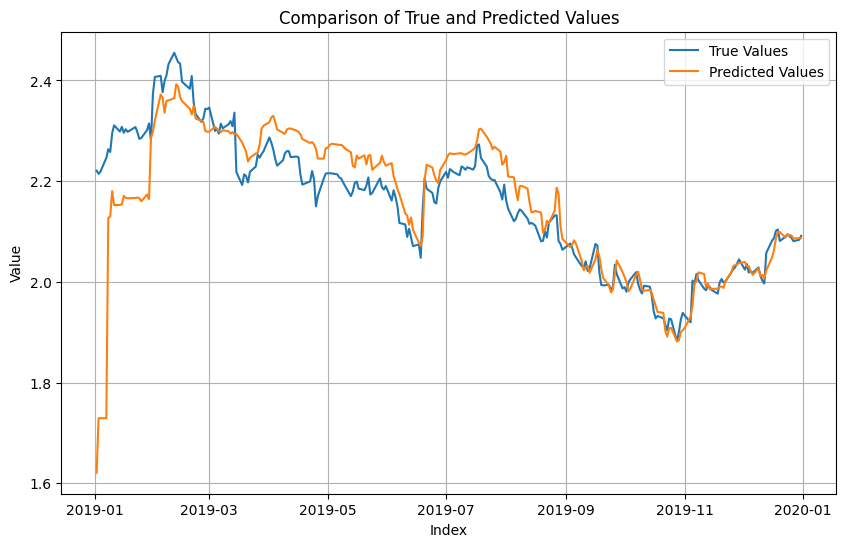

In [ ]:
y_pred1=model.predict(df1[['mavg5', 'mavg20', 'mavg60', 'roc', 'std_20', 'lag']])

mse = mean_squared_error(df1['ratio'], y_pred1)
mae = mean_absolute_error(df1['ratio'], y_pred1)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

plt.figure(figsize=(10, 6))
plt.plot(df1['ratio'].index, df1['ratio'], label="True Values")
plt.plot(df1['ratio'].index, y_pred1, label="Predicted Values")

# Add labels, title, and legend
plt.title("Comparison of True and Predicted Values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
df1['Predicted_Ratio'] = np.nan
df1.iloc[-len(df1['ratio']):, df1.columns.get_loc('Predicted_Ratio')] = y_pred1

In [ ]:
df1['Buy_Signal'] = (df1['Predicted_Ratio'] > df1['ratio'] + mae / 5)
df1['Sell_Signal'] = (df1['Predicted_Ratio'] + mae / 5 < df1['ratio'])

df1['PnL'] = 0
positions1 = {'ADBE': 0, 'MSFT': 0}

# Iterate over positional indices and access the actual index via df.index
for i in range(len(df1)):
    idx = df1.index[i]  # Get the actual index value

    if df1.loc[idx, 'Buy_Signal']:  # Use loc with the index value
        positions1['ADBE'] += 10
        positions1['MSFT'] -= 10
    elif df1.loc[idx, 'Sell_Signal']:
        positions1['ADBE'] -= 10
        positions1['MSFT'] += 10

    # Update PnL
    df1.loc[idx, 'PnL'] = positions1['ADBE'] * df1.loc[idx, 'ADBE'] + positions1['MSFT'] * df1.loc[idx, 'MSFT']

# Filter rows where 'Predicted_Ratio' is not NaN
filtered_df1 = df1[df1['Predicted_Ratio'].notna()]

# Calculate PnL change
filtered_df1['PnL_Change'] = filtered_df1['PnL'].diff()

print(filtered_df1[['PnL']])


Ticker                PnL
Date                     
2019-01-02   -1234.500046
2019-01-03   -2365.999908
2019-01-04   -3727.800064
2019-01-07   -5087.999878
2019-01-08   -6493.999481
...                   ...
2019-12-24  122304.606934
2019-12-26  122496.309967
2019-12-27  121999.301300
2019-12-30  121232.500000
2019-12-31  122198.100433

[252 rows x 1 columns]


<ipython-input-30-4616a3882845>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1234.5000457763672' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.loc[idx, 'PnL'] = positions1['ADBE'] * df1.loc[idx, 'ADBE'] + positions1['MSFT'] * df1.loc[idx, 'MSFT']


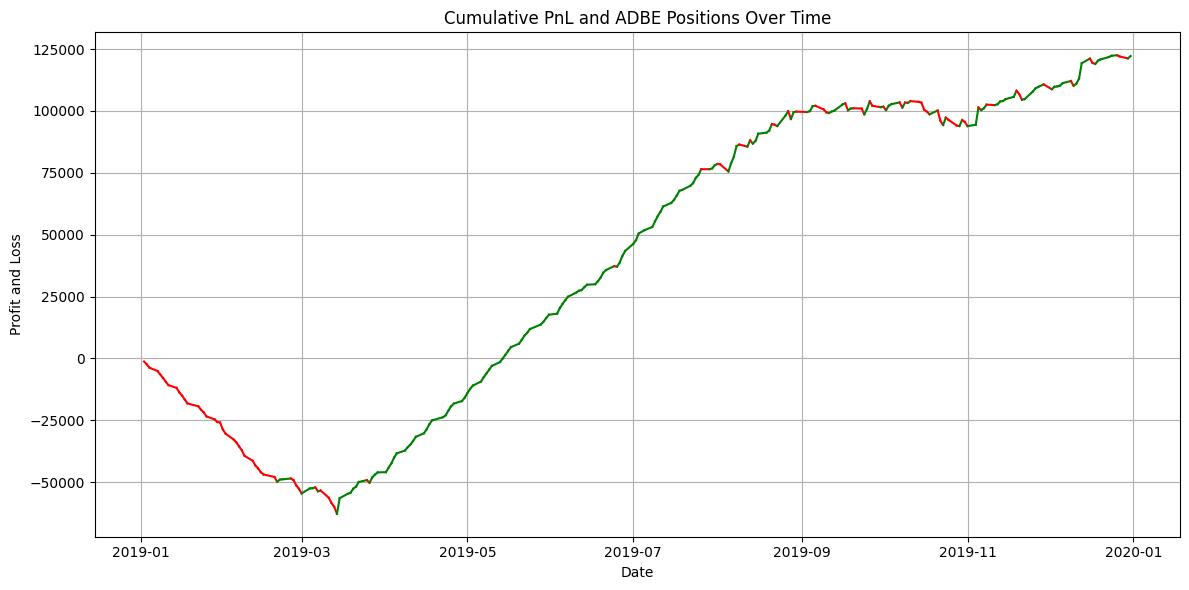

In [ ]:
# Plot the PnL with color-coded segments
fig, ax1 = plt.subplots(figsize=(12, 6))

for i in range(1, len(filtered_df1)):
    if filtered_df1['PnL_Change'].iloc[i] > 0:  # PnL is increasing
        ax1.plot(filtered_df1.index[i-1:i+1],
                 filtered_df1['PnL'].iloc[i-1:i+1],
                 color='green')
    else:  # PnL is decreasing
        ax1.plot(filtered_df1.index[i-1:i+1],
                 filtered_df1['PnL'].iloc[i-1:i+1],
                 color='red')

# Customize the primary y-axis
ax1.set_title("Cumulative PnL and ADBE Positions Over Time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Profit and Loss")
ax1.tick_params(axis='y', labelcolor='black')

# # Create a secondary y-axis for the bar graph (ADBE positions only)
# ax2 = ax1.twinx()
# ax2.bar(filtered_df.index, filtered_df['ADBE_Position'], color='blue', alpha=0.3, width=1)
# ax2.set_ylabel("ADBE Positions", color='blue')
# ax2.tick_params(axis='y', labelcolor='blue')

# Show the plot
plt.tight_layout()
plt.grid()
plt.show()